# Navigation

---

This report details the development of the DRL used to train the Unity ML-Agents agent to navigate and catch bananas.

### 1. Starting the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
%matplotlib inline

To start the environment, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
# Change according to the downloaded environment
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 3. Training the agent
Training is done using the Deep Q-Learning Algorithm.

In the sampling step the agent performs actions using an $\epsilon\textrm{-Greedy}$ policy:

$ \pi \leftarrow \epsilon\textrm{-Greedy}(\hat{q} (S,A,w)) $

It performs an action $A$ from an state $S$, observes reward $R$ and obtains the next state $S'$ and stores the experience tuple $(S,A,R,S')$ in the replay buffer $D$. 
In this case we have direct access to the state vector so we do not need to prepare the $S'$ state vector from the input frames.
The ReplayBuffer class has methods to add and sample randomly from the replay memory.

Learning is performed every UPDATE_EVERY time steps. In this procedure obtains random minibatches of $(s_j,a_j,r_j,s_{j+1})$ tuples from the replay buffer. The number of tuples sampled is set by BATCH_SIZE variable.

Then the target is set to $y_j = r_j + \gamma \max_a \hat{q} (s_{j+1},a,w^-)$, so the model parameters are updated with:

$\Delta w = \alpha \cdot \overbrace{( \underbrace{r_j + \gamma \max_a\hat{q}(s_{j+1}, a, w^-)}_{\rm {TD~target}} - \underbrace{\hat{q}(s_j, a_j, w)}_{\rm {old~value}})}^{\rm {TD~error}} \nabla_w\hat{q}(s_j, a_j, w)$

Every UPDATE_EVERY steps we reset ${w^- \leftarrow w}$.

The hiperparameters used are shown below:

| Parameter |  Variable  | Value |
|-----------|------------|------|
|Size of the replay buffer D|BUFFER_SIZE|1e5|
|Mini-batch size|BATCH_SIZE|64|
|Discount factor|GAMMA|0.99|
|$\tau$ for soft update of target parameters|TAU|1e-3|
|Learning rate|LR|5e-4|
|How often to update the network|UPDATE_EVERY|4|


A multilayer perceptron neural network is used to approximate the optimal action-value function.
The network is modeled in the file model.py with PyTorch.
The input size of the network is equal to the state size, i.e., 37 as shown above. 
The first hidden layer has 64 units, as well as the second. The network generates an output with size equals to the action size.
The activation function used is RELU. 

To train your own agent to solve the environment set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Episode 100	Average Score: 0.55
Episode 200	Average Score: 4.06
Episode 300	Average Score: 7.33
Episode 400	Average Score: 9.92
Episode 476	Average Score: 13.03
Environment solved in 376 episodes!	Average Score: 13.03


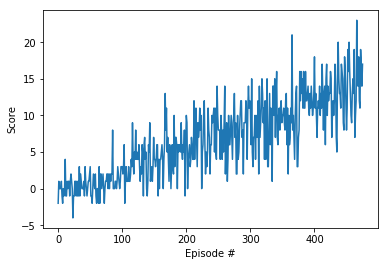

In [6]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]  
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

env.close()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

 The same can be done with the file train.py
```bash
python train.py
```

### 4. Testing 

After training is successful a checkpoint.pth will be generated. The test script will load and interact with the environment. To test the trained agent:
```bash
python test.py
```

### 5. Ideas for Future Work

To improve the agent`s performance first we could tune the hyperparameters and number of nodes of the neural network hidden layers. 

It also would be interesting to test the performance of Double DQN or Dueling DQN.